## Ising Model GAN 

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "..")
import time
from IPython import display
from model import RegressionModel
from pathlib import Path
data_path = Path("../../GetData/Python/Data")

2024-03-28 10:28:22.652803: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf

def train_step(batch, gen_loss_log, disc_loss_log, batch_size, noise_dim, generator, discriminator, generator_optimizer, discriminator_optimizer, regression_model):
      noise = tf.random.normal([batch_size, noise_dim])
      images, temps = batch
    
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generator's images
        generated_images = generator(noise, training=True)
        #estimated_temps = regression_model(generated_images)

        # Discriminator part  
        real_logits = discriminator(images, training=True)
        generated_logits = discriminator(generated_images, training=True)

        # Cost Function
        gen_loss = generator_loss(generated_logits, temps, temps)
        gen_loss_log.append(gen_loss)
        disc_loss = discriminator_loss(real_logits, generated_logits)
        disc_loss_log.append(disc_loss)
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def generator_loss(generated_logits, estimated_temps, temps, lambda2 = 1e3):
    l1 = tf.reduce_mean(tf.losses.binary_crossentropy(tf.ones_like(generated_logits), generated_logits))
    l2 = tf.reduce_mean(tf.losses.mean_squared_error(estimated_temps, temps))
    return l1 + lambda2 * l2

def discriminator_loss(real_image, generated_image):
    real_loss = tf.losses.binary_crossentropy(tf.ones_like(real_image), real_image, from_logits = True)
    generated_loss = tf.losses.binary_crossentropy(tf.zeros_like(generated_image), generated_image, from_logits = True)
    total_loss = real_loss + generated_loss
    return total_loss

def make_generator_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(4 * 4 * 1024, use_bias=False, input_shape=(100,)))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Reshape((4, 4, 1024)))
    assert model.output_shape == (None, 4, 4, 1024)
    
    model.add(tf.keras.layers.Conv2DTranspose(512, (1, 1), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None,  8, 8, 512)  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 256)  
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)    
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation=tf.sigmoid))

    assert model.output_shape == (None, 32, 32, 1)
    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(8, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dropout(0.5))
      
    model.add(tf.keras.layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
     
    return model


In [6]:
import tensorflow as tf
from input_pipeline import dataset_tfrecord_pipeline

class DataIterator:
    def __init__(self, datasets, temps):
        self.datasets = datasets
        self.temps = temps
    def __iter__(self):
        self.data_iterators = [iter(data) for data in self.datasets]
        return self
    
    def __next__(self):
        data_list = []
        temp_list = []
        for index, data_iterator in enumerate(self.data_iterators):
            data = next(data_iterator)
            data_list.append(data)
            temp = self.temps[index] * np.ones((data.shape[0], 1))
            temp_list.append(temp)
        temps = tf.concat(temp_list, axis=0)
        data = tf.concat(data_list, axis=0)
        return data, temps
        
def make_dataset(data_dir, temps, batch_size=100, flatten=False):
    if isinstance(data_dir, str):
        data_dir = Path(data_dir)
    
    assert batch_size % len(temps) == 0, "Batch size must be divisible by the number of temperatures"

    trainset = []
    testset = []
    for temp in temps:
        dataset = dataset_tfrecord_pipeline(data_dir / f"Data{temp:.1f}.tfrecord", flatten=flatten, batch_size=batch_size // len(temps))
        trainset.append(dataset)
        dataset = dataset_tfrecord_pipeline(data_dir / f"TestData{temp:.1f}.tfrecord", flatten=flatten, batch_size=batch_size // len(temps))
        testset.append(dataset)
    gen_test = DataIterator(testset, temps)
    test_dataset = tf.data.Dataset.from_generator(lambda: gen_test, output_signature = (tf.TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32), tf.TensorSpec(shape=(None, 1), dtype=tf.float32)))
    gen_train = DataIterator(trainset, temps)
    train_dataset = tf.data.Dataset.from_generator(lambda: gen_train, output_signature = (tf.TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32), tf.TensorSpec(shape=(None, 1), dtype=tf.float32)))
    return train_dataset, test_dataset

In [7]:
temps = [2.2]
batch_size = 120
train_dataset, _ = make_dataset(data_path, temps, batch_size=batch_size, flatten=False)

In [8]:
from datetime import datetime
from pathlib import Path
# Get the current date and time
current_datetime = datetime.now()

# Format it to include date, hour, and minutes
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M")

results = Path("results/" + formatted_datetime)
results.mkdir()

In [9]:
def generate_and_save_images(model, epoch, test_input):
    predictions = tf.round(model(test_input, training=False))
    
    plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0])
      plt.axis('off')
        
    plt.savefig(results / 'image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()
    
    fig, ax1 = plt.subplots()
    
    ax1.plot(np.asarray(disc_loss_log), color='tab:red')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Discriminator Loss', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    
    ax2 = ax1.twinx()
    ax2.plot(np.asarray(gen_loss_log), color='tab:blue')
    ax2.set_ylabel('Generator Loss', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    plt.show()

def train(dataset, epochs, batch_size, gen_loss_log, disc_loss_log, regression_model):  
  for epoch in range(epochs):
    start = time.time()

    for batch in tqdm(dataset): 
      train_step(
             batch, 
             gen_loss_log, 
             disc_loss_log, 
             batch_size, 
             noise_dim, 
             generator, 
             discriminator, 
             generator_optimizer, 
             discriminator_optimizer,
             regression_model)

    display.clear_output(wait=True) 
    generate_and_save_images(
      generator,
      epoch + 1,
      random_vector_for_generation
    ) 
    print (f"Time taken for epoch {epoch} is {time.time()- start} sec")
    

noise_dim = 100
num_examples_to_generate = 16
random_vector_for_generation = tf.random.normal([num_examples_to_generate,
                                                 noise_dim])
generator = make_generator_model()
discriminator = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)
regression_model = tf.keras.models.load_model("results/regression_model")

In [10]:
discriminator.build(input_shape = (None, 32, 32, 1))
discriminator.summary()
generator.build(input_shape = (None, 100))
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 8)         208       
                                                                 
 batch_normalization_3 (Bat  (None, 16, 16, 8)         32        
 chNormalization)                                                
                                                                 
 re_lu (ReLU)                (None, 16, 16, 8)         0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          3216      
                                                                 
 batch_normalization_4 (Bat  (None, 8, 8, 16)          64        
 chNormalization)                                     

# Train

In [15]:
for image, temp in train_dataset.take(1):
    print(f"Image encoding {tf.math.reduce_min(image)}, {tf.math.reduce_max(image)}")
    print("Image shape:", image.shape)
    print("Temp shape:", temp.shape)

Image encoding 0.0, 1.0
Image shape: (120, 32, 32, 1)
Temp shape: (120, 1)


In [16]:
EPOCHS=5
gen_loss_log=[]
disc_loss_log=[]

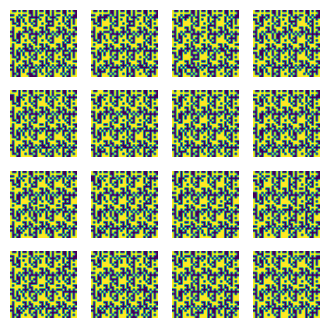

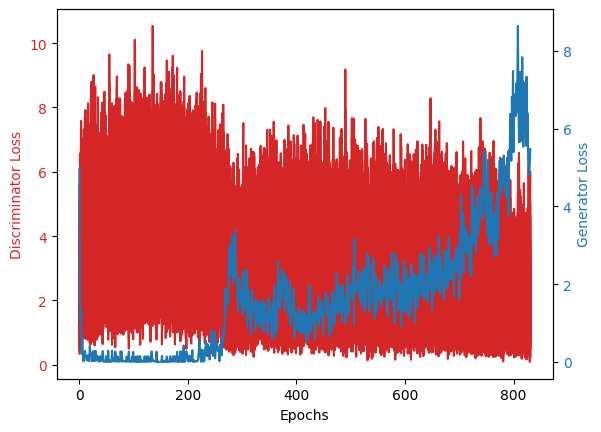

Time taken for epoch 1 is 143.69302773475647 sec


357it [01:10,  5.98it/s]

In [ ]:
%%time
train(train_dataset, EPOCHS, batch_size, gen_loss_log, disc_loss_log, regression_model)

## Plot the loss of the generator and discriminator

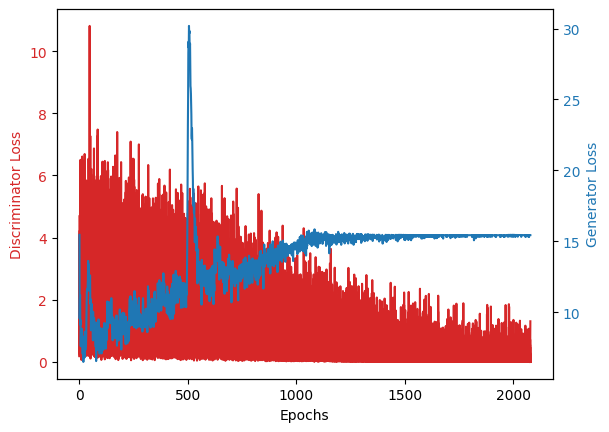

In [14]:
fig, ax1 = plt.subplots()

ax1.plot(np.asarray(disc_loss_log), color='tab:red')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Discriminator Loss', color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.plot(np.asarray(gen_loss_log), color='tab:blue')
ax2.set_ylabel('Generator Loss', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.show()

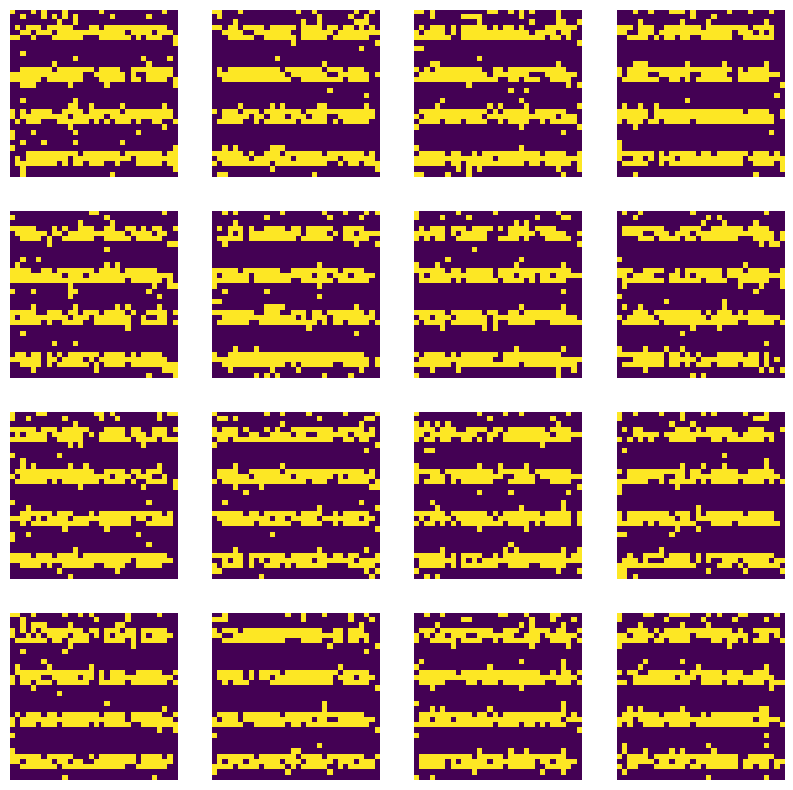

In [29]:
plt.figure(figsize=(10, 10))
predictions = generator(random_vector_for_generation, training=False)
for i in range(16):
    plt.subplot(4, 4, i+1)
    spins = np.random.binomial(1, predictions[i, :, :])
    plt.imshow(spins)
    plt.axis('off')
plt.show()

# Average magnetization

In [22]:
data = []
for image, temps in train_dataset.take(1):
    mag = np.sum(image)
    data.append(np.hstack((mag, temps))
    print(image.shape)
    print(temps.shape)
    print(mag.shape)




(110, 32, 32, 1)
(110, 1)
